In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 1.데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv",index_col='Id') 
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv",index_col='Id')
train_test = [train,test]
submission=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv',index_col='Id')
data=train
print(train.shape, test.shape, submission.shape)

(1460, 80) (1459, 79) (1459, 1)


# 2. 데이터 분석하기


## target 변수 확인


In [4]:
# 변수 보기
print(train.columns.values)

['MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleType' '

In [5]:
#train.info() #found column that has NAN

In [6]:
#test.info()

In [7]:
#pd.set_option('display.max_rows', 100)
#train.dtypes

<Axes: xlabel='SalePrice', ylabel='Density'>

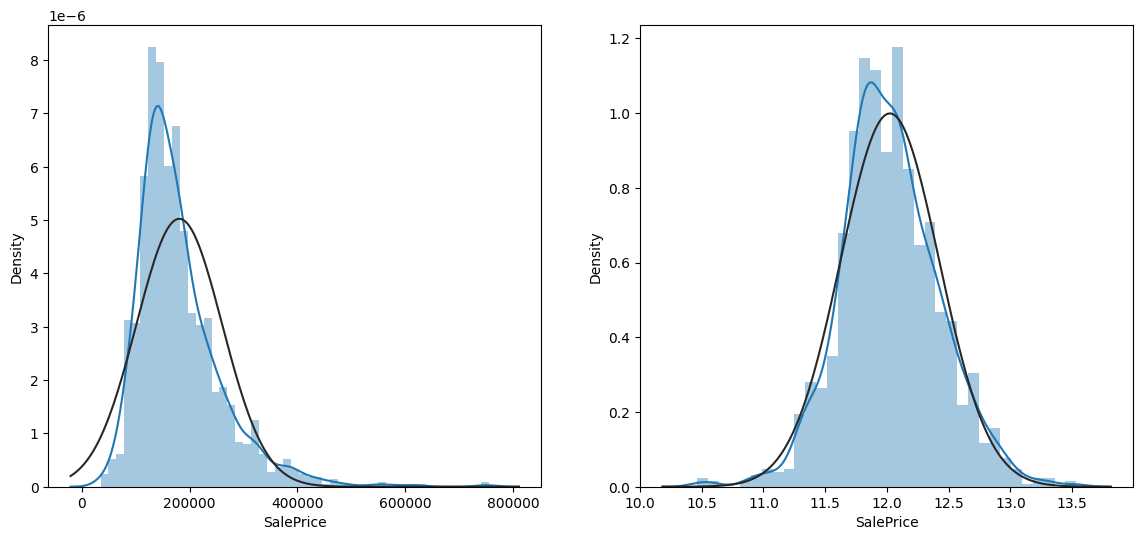

In [8]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(data['SalePrice'], fit=norm, ax=ax1) # 타겟변수의 분포
sns.distplot(np.log(data['SalePrice']+1), fit=norm, ax=ax2)#타겟변수에 로그를 취한 분포

심한 비대칭은 머신러닝 알고리즘이 학습을 잘 하지 못하도록 방해하는 요소 중 하나임
대부분의 데이터가 왼쪽에 있다면, 오른쪽 꼬리 부분은 데이터가 적어서 학습이 잘 안될 가능성이 있음
따라서 예측 결과물도 의심할 수 밖에 없기에 이런 상황에서 'Right Skewed' 를 해결하는 대표적인 방법이 바로 해당 변수에 로그를 취하는것

## 변수간 상관관계 확인

<Axes: >

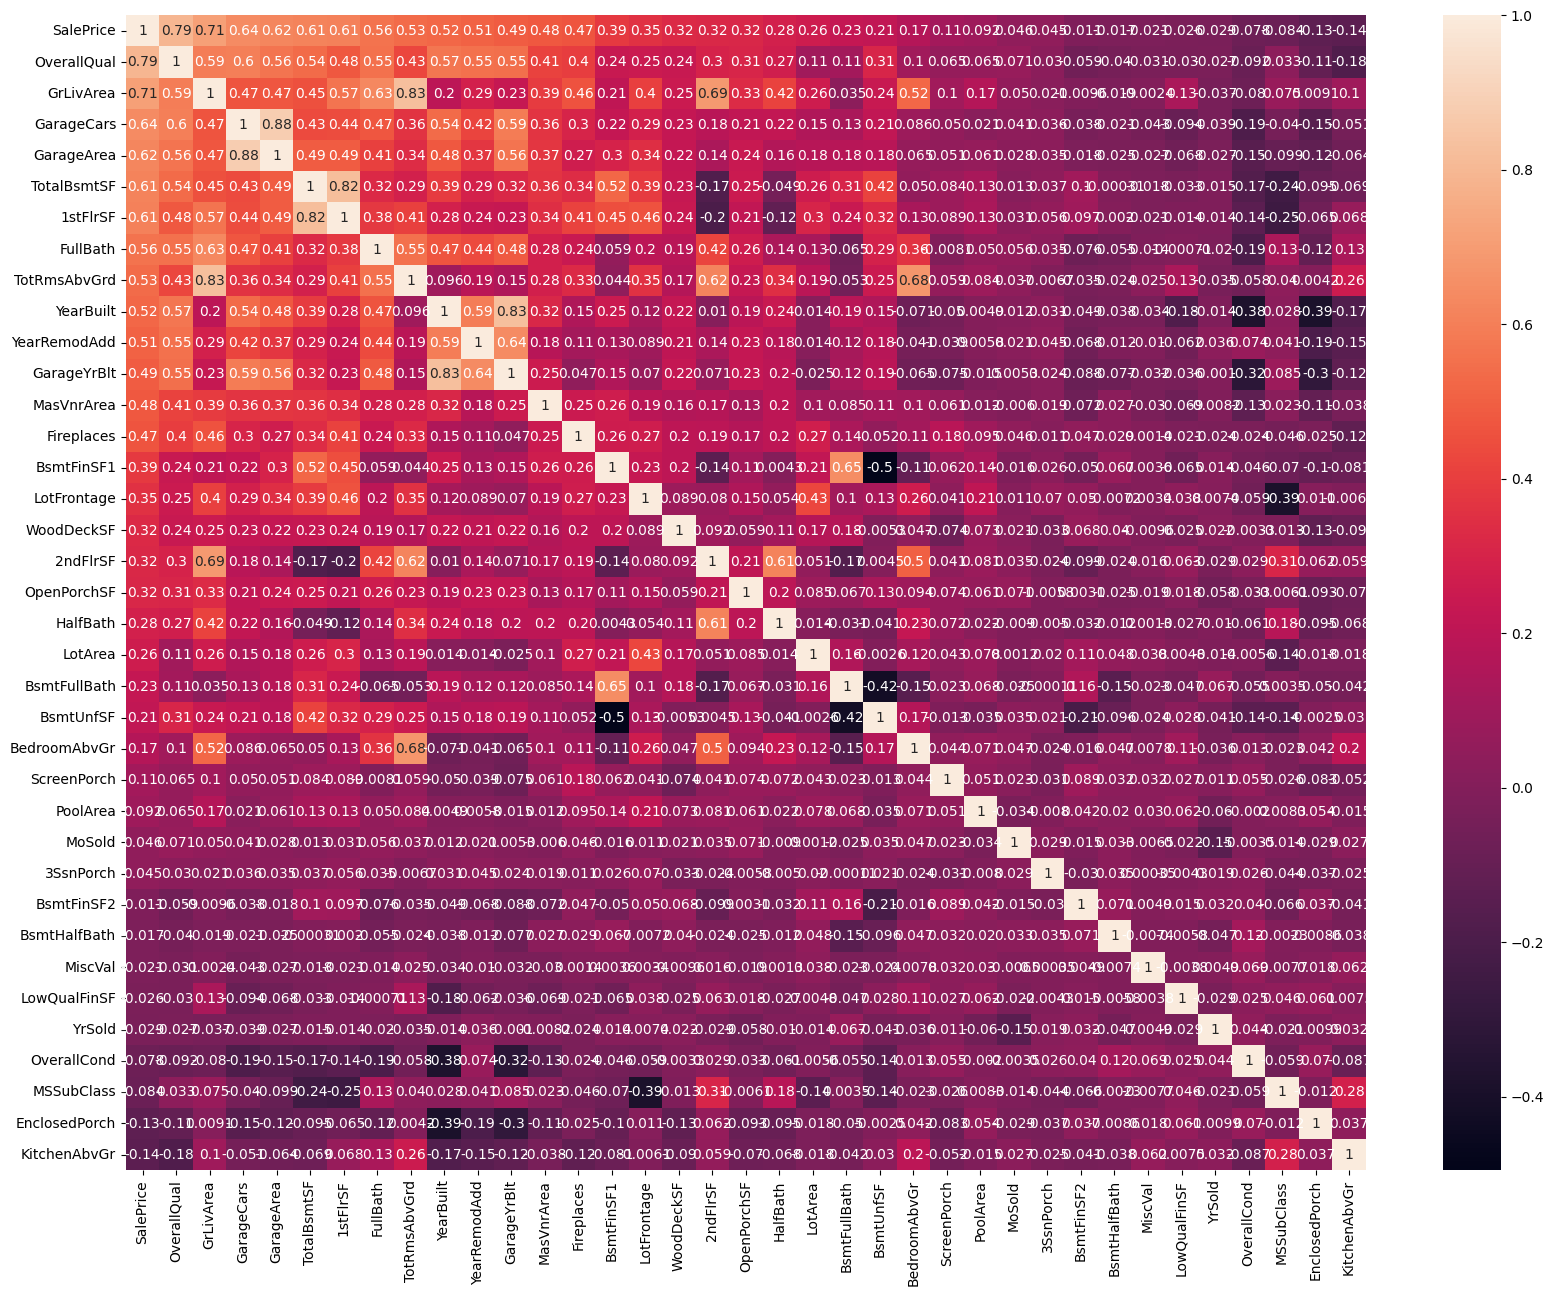

In [9]:
numeric_data = data.select_dtypes(include=[np.number])
corr = numeric_data.corr()
top_corr = numeric_data[corr.nlargest(40, 'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(20, 15)
sns.heatmap(top_corr, annot=True, ax=ax1)


데이터프레임에서 숫자형 열만 선택하여 상관관계를 계산함

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

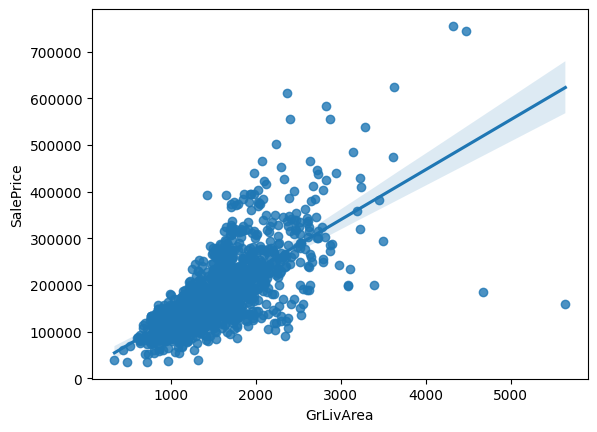

In [10]:
sns.regplot(x=data['GrLivArea'], y=data['SalePrice'])

In [11]:
#오른쪽 아래 점 두개가 이상치로 간주하고 삭제해줘야함
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [12]:
#train과 test data 합치기
Ytrain=train['SalePrice'] # 타겟 변수를 미리 Ytrain으로 빼서 로그취함
train=train[list(test)]
all_data=pd.concat((train, test), axis=0)
print(all_data.shape)
Ytrain=np.log(Ytrain+1) # 1을 더하는 이유는 log0값은 존재하지 않기때문

(2917, 79)


## 결측값 확인

In [13]:
cols=list(all_data)
for col in list(all_data):
    if (all_data[col].isnull().sum())==0:
        cols.remove(col) # 결측치가 없으면 그 열의 이름을 지움
    else:
        pass
print(len(cols))
print(cols)

34
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [14]:
# 범주형 변수(시설물이 없어 결측치로 처리된 경우)
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

# 수치형 변수(시설물이 없어 결측치로 처리된 경우)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)

# 시설물이 없는게 아닌 경우 최빈값으로 채움    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print(f"Total cnt of missing values in all_data : {all_data.isnull().sum().sum()}")

Total cnt of missing values in all_data : 0


## 데이터 분석

<Axes: ylabel='SalePrice'>

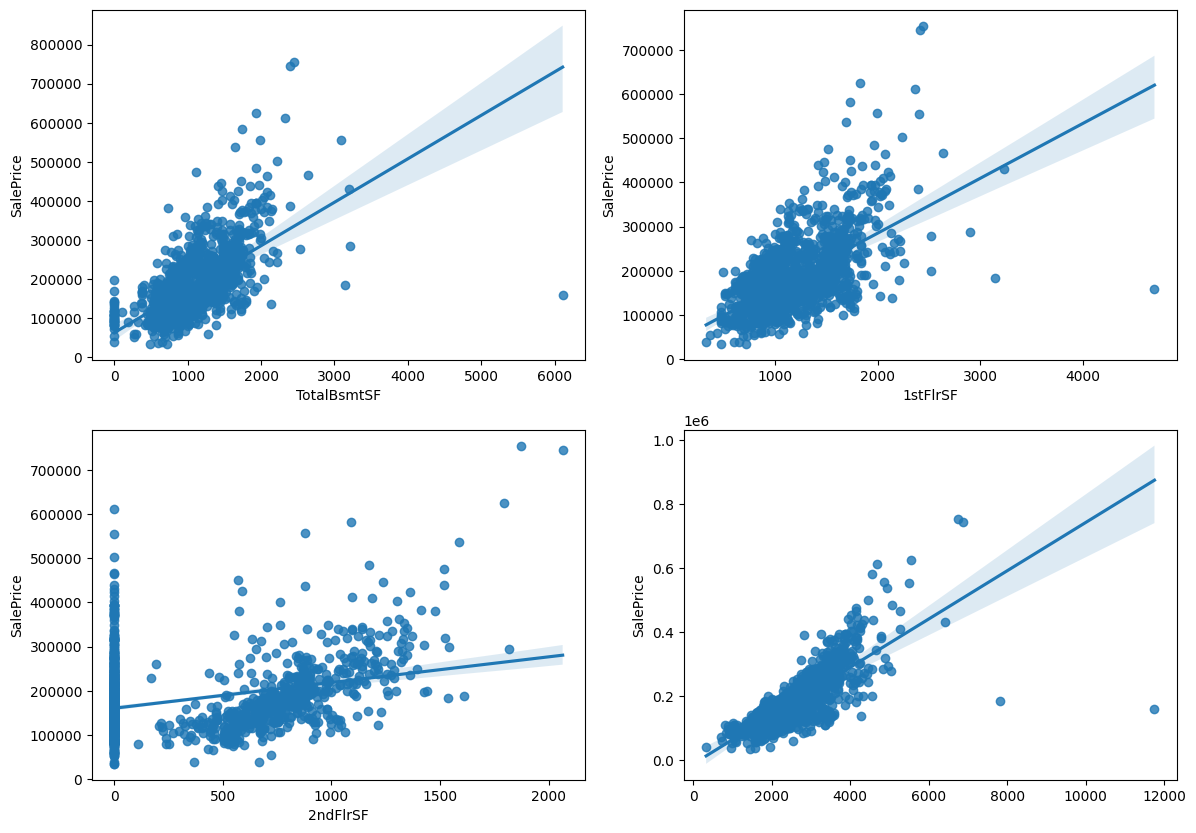

In [15]:
# 지하실 + 1층 + 2층 면적을 합친 하나의 새로운 변수 생성
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14, 10)
sns.regplot(x=data['TotalBsmtSF'], y=data['SalePrice'], ax=ax1)
sns.regplot(x=data['1stFlrSF'], y=data['SalePrice'], ax=ax2)
sns.regplot(x=data['2ndFlrSF'], y=data['SalePrice'], ax=ax3)
sns.regplot(x=data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'], y=data['SalePrice'], ax=ax4)

오른쪽 맨 아래의 그래프가 총 면적 그래프인데 타겟변수와 상당히 관련있음을 확인할 수 있음

In [16]:
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['No2ndFlr']=(all_data['2ndFlrSF']==0)
all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)

No2ndFlr' 과 'NoBsmt' 라는 변수생성
 : 면적 그래프를 살펴보면 직선과 찍힌 점들이 맞지않는걸 볼 수 있음
 : 저 0들을 따로 변수로 분리해보기로 결정

<Axes: ylabel='SalePrice'>

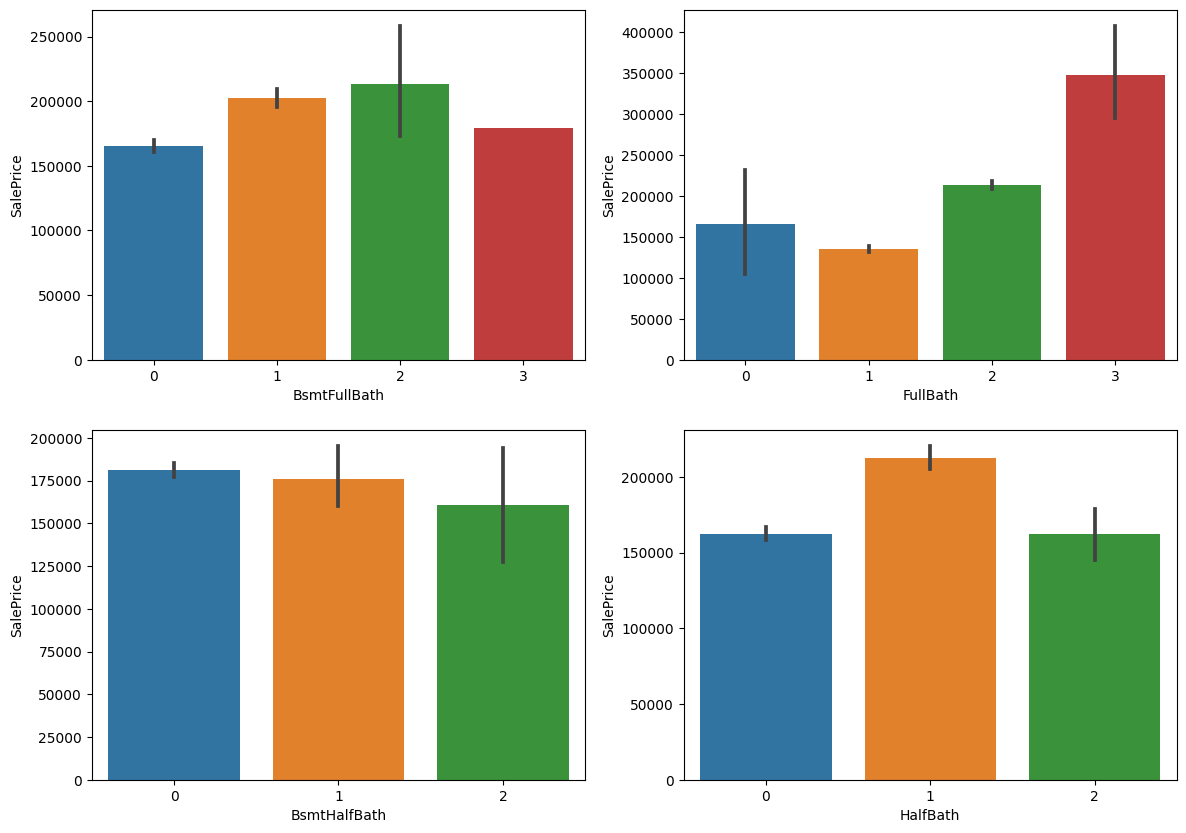

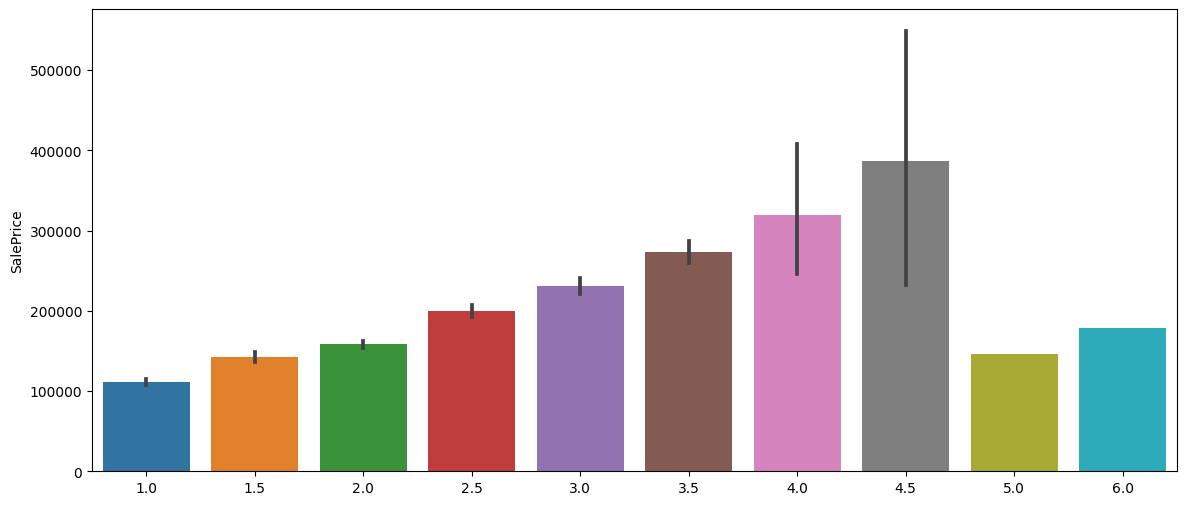

In [17]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(x=data['BsmtFullBath'], y=data['SalePrice'], ax=ax1)
sns.barplot(x=data['FullBath'], y=data['SalePrice'], ax=ax2)
sns.barplot(x=data['BsmtHalfBath'], y=data['SalePrice'], ax=ax3)
sns.barplot(x=data['HalfBath'], y=data['SalePrice'], ax=ax4)

figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(x=data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2), y=data['SalePrice'], ax=ax5)


욕실개수는 총 4개의 열로 이루어져있고, 이들을 모두 합쳐서 count해본 결과(full = 1.0, half = 0.5) 욕실수가 많을수록 욕실이 많을수록 집값이 상승
이때 5개, 6개인 집들은 편차를 의미하는 검정 막대기가 존재하지 x
 : 이말은 곧 욕실수가 5개, 6개인 집은 1개씩이라는 것을 의미하고 outlier로 판단하고 삭제해도 무관함

In [18]:
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

<Axes: ylabel='SalePrice'>

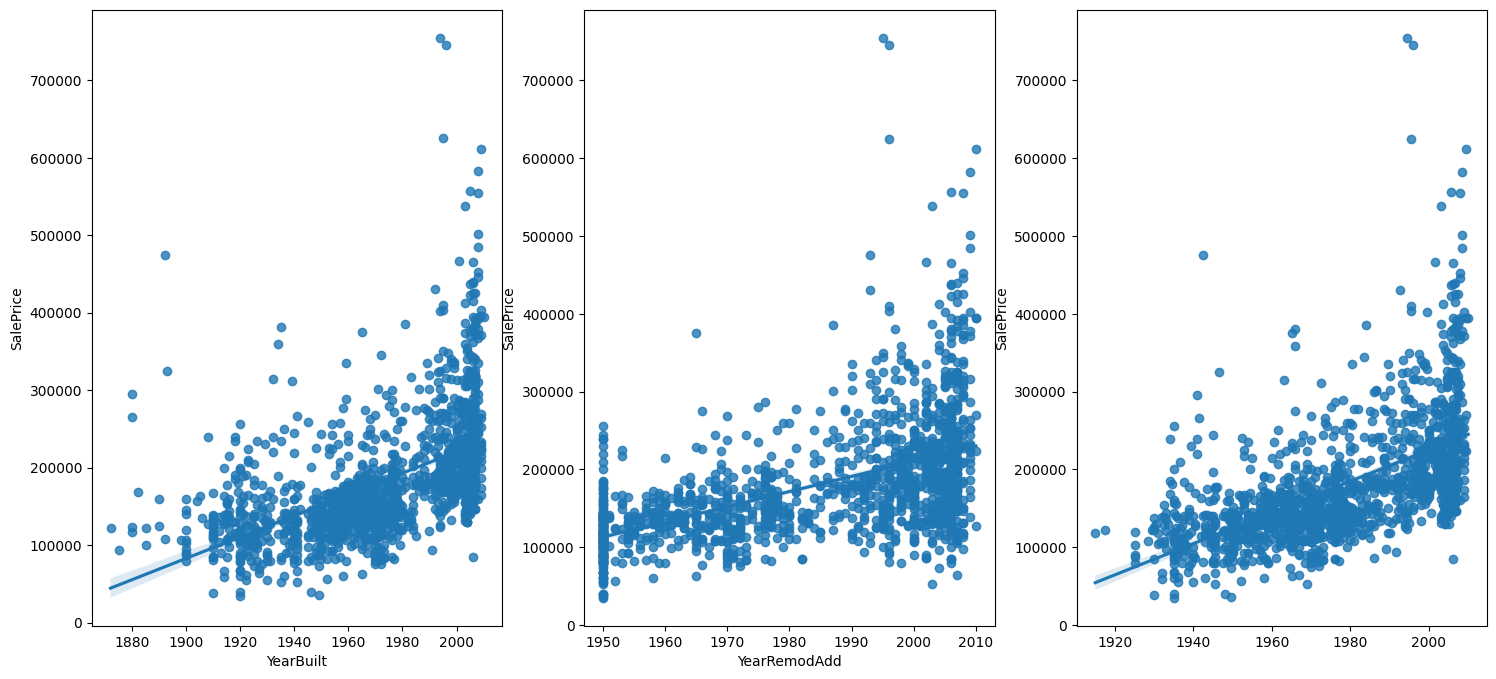

In [19]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18, 8)
#건축연도
sns.regplot(x=data['YearBuilt'], y=data['SalePrice'], ax=ax1)
#리모델링 연도
sns.regplot(x=data['YearRemodAdd'], y=data['SalePrice'], ax=ax2)
#이 두개의 평균
sns.regplot(x=(data['YearBuilt'] + data['YearRemodAdd']) / 2, y=data['SalePrice'], ax=ax3)  # '/2' for graph scaling

건축연도와 리모델링 연도는 매우 유사한 형태의 그래프임을 알 수있음
이 둘의 평균을 구한 이유는  건축 연도가 오래 되었어도, 최근에 리모델링을 하면 이 값이 높게 나왔을 것이고, 건축 이후 리모델링을 하지 않았다면 이 값은 아주 낮게 나왔을 것. 즉 이 값이 높은 집들은 '지어진지 얼마 되지 않은 신축 건물 + 최근에 리모델링까지함' 에 가깝고, 이 값이 낮은 집들은 '오래된 건물 + 리모델링도 안함' 에 가까울 것
 그리고 평균 그래프를 찍어봤을때 무의미하지 않다는 것은 알 수있음

In [20]:
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

In [21]:
#자료형 수정(숫자로 이루어진 데이터지만 각각의 숫자가 의미를 지니고있으므로)
all_data['MSSubClass']=all_data['MSSubClass'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)
all_data['YrSold']=all_data['YrSold'].astype(str)

In [22]:
# 지하실 관련 변수들
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt=all_data[Basement]

In [23]:
Bsmt=Bsmt.replace(to_replace='Po', value=1)
Bsmt=Bsmt.replace(to_replace='Fa', value=2)
Bsmt=Bsmt.replace(to_replace='TA', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)
Bsmt=Bsmt.replace(to_replace='Ex', value=5)
Bsmt=Bsmt.replace(to_replace='None', value=0)

Bsmt=Bsmt.replace(to_replace='No', value=1)
Bsmt=Bsmt.replace(to_replace='Mn', value=2)
Bsmt=Bsmt.replace(to_replace='Av', value=3)
Bsmt=Bsmt.replace(to_replace='Gd', value=4)

Bsmt=Bsmt.replace(to_replace='Unf', value=1)
Bsmt=Bsmt.replace(to_replace='LwQ', value=2)
Bsmt=Bsmt.replace(to_replace='Rec', value=3)
Bsmt=Bsmt.replace(to_replace='BLQ', value=4)
Bsmt=Bsmt.replace(to_replace='ALQ', value=5)
Bsmt=Bsmt.replace(to_replace='GLQ', value=6)

data description 텍스트 파일을 통해서 ''안의 값을 확인
좋은값에는 높은숫자를 좋지않은 값에는 낮은 숫자를 지하실이 없으면 0을 할당

In [24]:
Bsmt['BsmtScore']= Bsmt['BsmtQual']  * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore']=Bsmt['BsmtScore']

Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore']=Bsmt['BsmtFin']
all_data['BsmtDNF']=(all_data['BsmtFinScore']==0)

'BsmtScore' 항목을 만들어 지하실의 전반적인 상태를 복합적으로 평가할 수 있는 변수 생성
'BsmtFinScore' 은 지하실의 완성도 점수, 'BsmtScore' 은 지하실의 종합 점수, 'BsmtDNF' 는 지하실의 미완성 여부를 나타내는 변수

In [25]:
#토지점수(토지관련 고려할 수 있는 점수들을 묶어 새로운 변수 생성)
lot=['LotFrontage', 'LotArea','LotConfig','LotShape']
Lot=all_data[lot]

Lot['LotScore'] = np.log((Lot['LotFrontage'] * Lot['LotArea'])+1)

all_data['LotScore']=Lot['LotScore']

In [26]:
#차고(차고관련 고려사항을 묶어 새로운 변수에 저장)
garage=['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage=all_data[garage]
all_data['NoGarage']=(all_data['GarageArea']==0)

In [27]:
Garage=Garage.replace(to_replace='Po', value=1)
Garage=Garage.replace(to_replace='Fa', value=2)
Garage=Garage.replace(to_replace='TA', value=3)
Garage=Garage.replace(to_replace='Gd', value=4)
Garage=Garage.replace(to_replace='Ex', value=5)
Garage=Garage.replace(to_replace='None', value=0)

Garage=Garage.replace(to_replace='Unf', value=1)
Garage=Garage.replace(to_replace='RFn', value=2)
Garage=Garage.replace(to_replace='Fin', value=3)

Garage=Garage.replace(to_replace='CarPort', value=1)
Garage=Garage.replace(to_replace='Basment', value=4)
Garage=Garage.replace(to_replace='Detchd', value=2)
Garage=Garage.replace(to_replace='2Types', value=3)
Garage=Garage.replace(to_replace='Basement', value=5)
Garage=Garage.replace(to_replace='Attchd', value=6)
Garage=Garage.replace(to_replace='BuiltIn', value=7)
Garage['GarageScore']=(Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) * (Garage['GarageQual']) * (Garage['GarageType'])
all_data['GarageScore']=Garage['GarageScore']

In [28]:
all_data=all_data.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])
#하나의 값에 너무 치우쳐진 변수들 삭제

<Axes: xlabel='PoolQC', ylabel='SalePrice'>

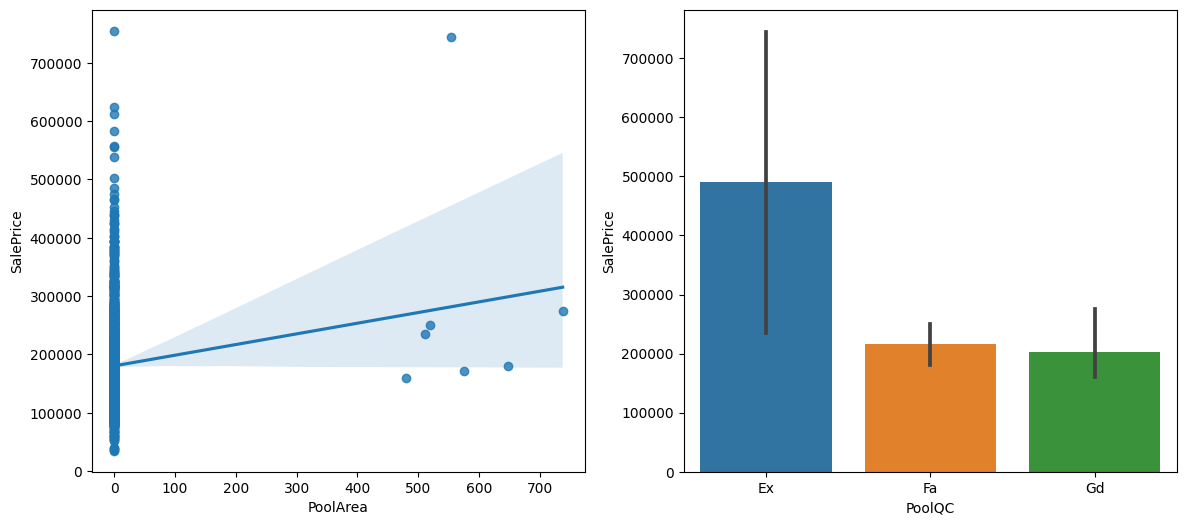

In [29]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='PoolArea', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='PoolQC', y='SalePrice', ax=ax2)

In [30]:
#결측값이 너무 많은 집은 삭제
all_data=all_data.drop(columns=['PoolArea','PoolQC'])

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

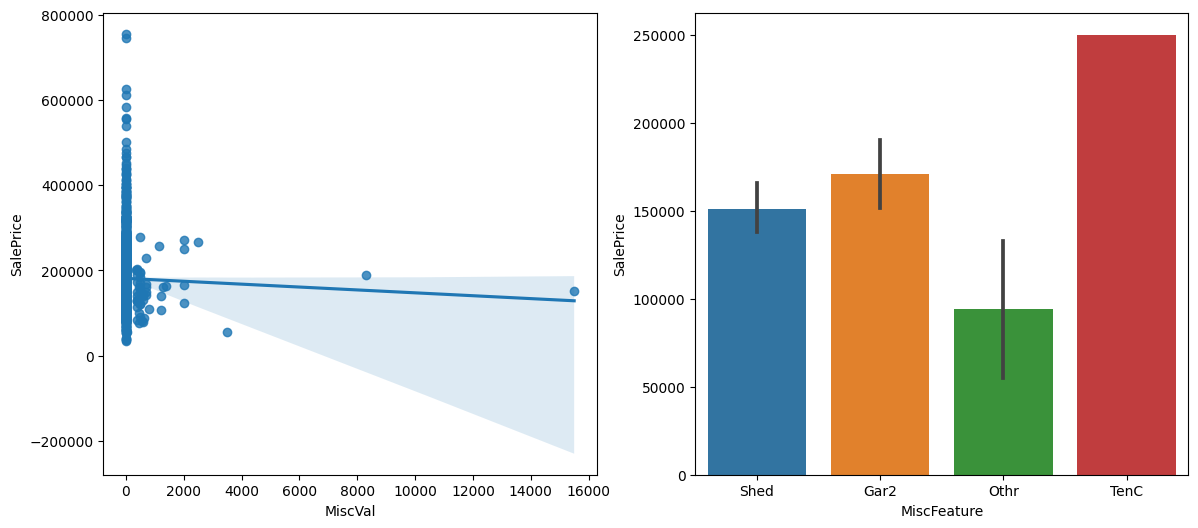

In [31]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=data, x='MiscVal', y='SalePrice', ax=ax1)
sns.barplot(data=data, x='MiscFeature', y='SalePrice', ax=ax2)

In [32]:
all_data=all_data.drop(columns=['MiscVal','MiscFeature'])

<Axes: xlabel='WoodDeckSF', ylabel='SalePrice'>

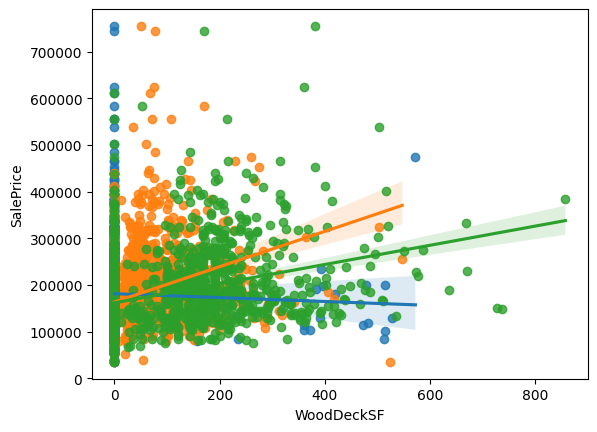

In [33]:
sns.regplot(data=data, x='LowQualFinSF', y='SalePrice')
sns.regplot(data=data, x='OpenPorchSF', y='SalePrice')
sns.regplot(data=data, x='WoodDeckSF', y='SalePrice')

In [34]:
# 채워진 결측지가 많은 경우 0 값만 분리
all_data['NoLowQual']=(all_data['LowQualFinSF']==0)
all_data['NoOpenPorch']=(all_data['OpenPorchSF']==0)
all_data['NoWoodDeck']=(all_data['WoodDeckSF']==0)

# 전처리

## 범주형 변수

In [35]:
non_numeric = all_data.select_dtypes(object)

def onehot(col_list):
    global all_data
    while len(col_list) != 0:
        col = col_list.pop(0)
        data_encoded = pd.get_dummies(all_data[col], prefix=col)
        all_data = pd.merge(all_data, data_encoded, on='Id')
        all_data = all_data.drop(columns=col)
    print(all_data.shape)

onehot(list(non_numeric))
#머신러닝이 오해하지않게 원핫인코딩 진행

(2917, 309)


## 수치형 변수

In [36]:
numeric=all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col=col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col]=np.log(all_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(all_data.shape)

log_transform(list(numeric))

26 features had been tranformed
(2917, 309)


In [37]:
#합쳤던 데이터를 다시 나누는 과정
print(train.shape, test.shape)
Xtrain=all_data[:len(train)]
Xtest=all_data[len(train):]
print(Xtrain.shape, Xtest.shape)

(1458, 79) (1459, 79)
(1458, 309) (1459, 309)


## 머신러닝 학습

In [38]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
model_Lasso= make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))

model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, 
                                         min_samples_split=10, loss='huber', random_state=18)

model_XGB=XGBRegressor(colsample_bylevel=0.9229733609038979,colsample_bynode=0.21481791874780318,colsample_bytree=0.607964318297635, 
                       gamma=0.8989889254961725, learning_rate=0.009192310189734834, max_depth=3, n_estimators=3602, 
                       reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13, seed=18, subsample=0.8381904293270576,
                       tree_method='gpu_hist',verbosity=0)

Lasso, ElasticNet, sklearn의 GradientBoosting, XGBoost 4개의 모델을 불러와서 저장

In [39]:
from xgboost import XGBRegressor

# 모델 정의
model_Lasso.fit(Xtrain, Ytrain)
Lasso_predictions = model_Lasso.predict(Xtest)
train_Lasso = model_Lasso.predict(Xtrain)

model_ENet.fit(Xtrain, Ytrain)
ENet_predictions = model_ENet.predict(Xtest)
train_ENet = model_ENet.predict(Xtrain)

model_XGB = XGBRegressor(tree_method='hist')  # 여기에 추가
model_XGB.fit(Xtrain, Ytrain)
XGB_predictions = model_XGB.predict(Xtest)
train_XGB = model_XGB.predict(Xtrain)

model_GBoost.fit(Xtrain, Ytrain)
GBoost_predictions = model_GBoost.predict(Xtest)
train_GBoost = model_GBoost.predict(Xtrain)

log_train_predictions = (train_Lasso + train_ENet + train_XGB + train_GBoost) / 4
train_score = np.sqrt(mean_squared_error(Ytrain, log_train_predictions))
print(f"Scoring with train data : {train_score}")

log_predictions = (Lasso_predictions + ENet_predictions + XGB_predictions + GBoost_predictions) / 4
predictions = np.exp(log_predictions) - 1
submission['SalePrice'] = predictions
submission.to_csv('Result.csv')


Scoring with train data : 0.05884126559581276
